### Import libraries

In [161]:
import numpy as np
import logging

In [162]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [163]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Dataset

### Load the data

In [164]:
dataset_dir = 'dataset'
dataset = np.load(f'{dataset_dir}/public_data.npz', allow_pickle=True)
X = dataset['data']
y = dataset['labels']
labels = {0:'healthy', 1:'unhealthy'}

print(f'Dataset Data Shape {X.shape}, type = {X[0].dtype}')
print(f'Dataset Labels Shape {y.shape}')


Dataset Data Shape (5200, 96, 96, 3), type = float32
Dataset Labels Shape (5200,)


## Inspect the data

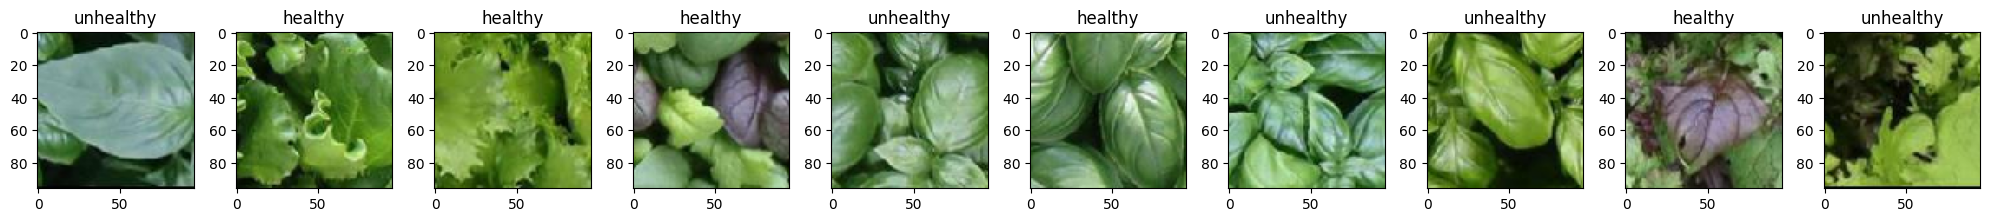

In [165]:
# Display a sample of images from the training-validation dataset
num_img = 10
to_show = np.random.randint(0, X.shape[0], num_img);
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i]
    ax.imshow(X[to_show[i]]/255)
    ax.set_title('{}'.format(y[to_show[i]]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()


In [166]:
# Display the count of occurrences of target classes in the training-validation dataset    
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
healthy      3199
unhealthy    2001
Name: class, dtype: int64


### Inspection consideration
1. Labels are not balanced
2. Outliers on the dataset are present
3. Labels are not correctly formatted 'healthy' -> 0, 'unhealthy' -> 1
4. Dataset is not normalized

## Preprocessing

### Labels encoding

In [167]:
def custom_label_encoder(data, encoding_preferences):
    encoded_data = np.array([encoding_preferences.get(val, -1) for val in data])
    return encoded_data

encoding = {
    'healthy': 0,
    'unhealthy': 1,
}
y = custom_label_encoder(y, encoding)

print(f'Dataset Labels Shape {y.shape}')
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['class'])['class'].value_counts())


Dataset Labels Shape (5200,)
Counting occurrences of target classes:
0    3199
1    2001
Name: class, dtype: int64


### Dataset normalized

In [168]:
X_norm = (X / 255).astype('float32')
print(f'Dataset Data Shape {X_norm.shape}')


Dataset Data Shape (5200, 96, 96, 3)


### Outliers

### Not balanced

In [179]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.1,
    stratify=y
)
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    stratify=y_train_val
)

# Print the shapes of the resulting datasets
print("Training_Validation Data Shape:", X_train_val.shape)
print("Training_Validation Label Shape:", y_train_val.shape)
print("Train Data Shape:", X_train.shape)
print("Train Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training_Validation Data Shape: (4680, 96, 96, 3)
Training_Validation Label Shape: (4680,)
Train Data Shape: (4160, 96, 96, 3)
Train Label Shape: (4160,)
Validation Data Shape: (520, 96, 96, 3)
Validation Label Shape: (520,)
Test Data Shape: (520, 96, 96, 3)
Test Label Shape: (520,)


In [170]:

# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of y_train classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())

print('Counting occurrences of y_val classes:')
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())

print('Counting occurrences of y_test classes:')
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Counting occurrences of y_train classes:
0    2559
1    1601
Name: class, dtype: int64
Counting occurrences of y_val classes:
0    320
1    200
Name: class, dtype: int64
Counting occurrences of y_test classes:
0    320
1    200
Name: class, dtype: int64


## Build LeNet model

In [176]:
def build_LeNet(input_shape, output_shape):

    model = tfk.Sequential(name='LeNet')

    model.add(tfkl.Input(shape=input_shape, name='Input'))
    # Layer 1: Convolutional layer with activation and max-pooling
    model.add(tfkl.Conv2D(6, kernel_size=(5, 5), padding='same', activation='tanh', name='conv1'))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), name='mp1'))

    # Layer 2: Convolutional layer with activation and max-pooling
    model.add(tfkl.Conv2D(16, kernel_size=(5, 5), padding='valid', activation='tanh', name='conv2'))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), name='mp2'))

    # Layer 3: Flatten
    model.add(tfkl.Flatten(name='Flatten'))

    # Layer 4: Fully connected layer with activation
    model.add(tfkl.Dense(120, activation='tanh', name='dense1'))

    # Layer 5: Fully connected layer with activation
    model.add(tfkl.Dense(84, activation='tanh', name='dense2'))

    # Output layer
    model.add(tfkl.Dense(output_shape, activation='softmax', name='Output'))

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model


def build_model_2(input_shape, output_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [172]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = 1  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (96, 96, 3)
Output Shape: 1


In [177]:
# Build the LeNet model and display its summary
model = build_model_2(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

### Train the model

In [178]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history


Epoch 1/200
33/33 [==============================] - 21s 619ms/step - loss: 3.7215 - accuracy: 0.3849 - val_loss: 0.6731 - val_accuracy: 0.3846
Epoch 2/200
33/33 [==============================] - 20s 612ms/step - loss: 0.6529 - accuracy: 0.3849 - val_loss: 0.6514 - val_accuracy: 0.3846
Epoch 3/200
33/33 [==============================] - 20s 618ms/step - loss: 0.6304 - accuracy: 0.3849 - val_loss: 0.6391 - val_accuracy: 0.3846
Epoch 4/200
33/33 [==============================] - 21s 627ms/step - loss: 0.6133 - accuracy: 0.3849 - val_loss: 0.6219 - val_accuracy: 0.3846
Epoch 5/200
33/33 [==============================] - 20s 609ms/step - loss: 0.5993 - accuracy: 0.3849 - val_loss: 0.6086 - val_accuracy: 0.3846
Epoch 6/200
33/33 [==============================] - 23s 689ms/step - loss: 0.6029 - accuracy: 0.3849 - val_loss: 0.7008 - val_accuracy: 0.3846


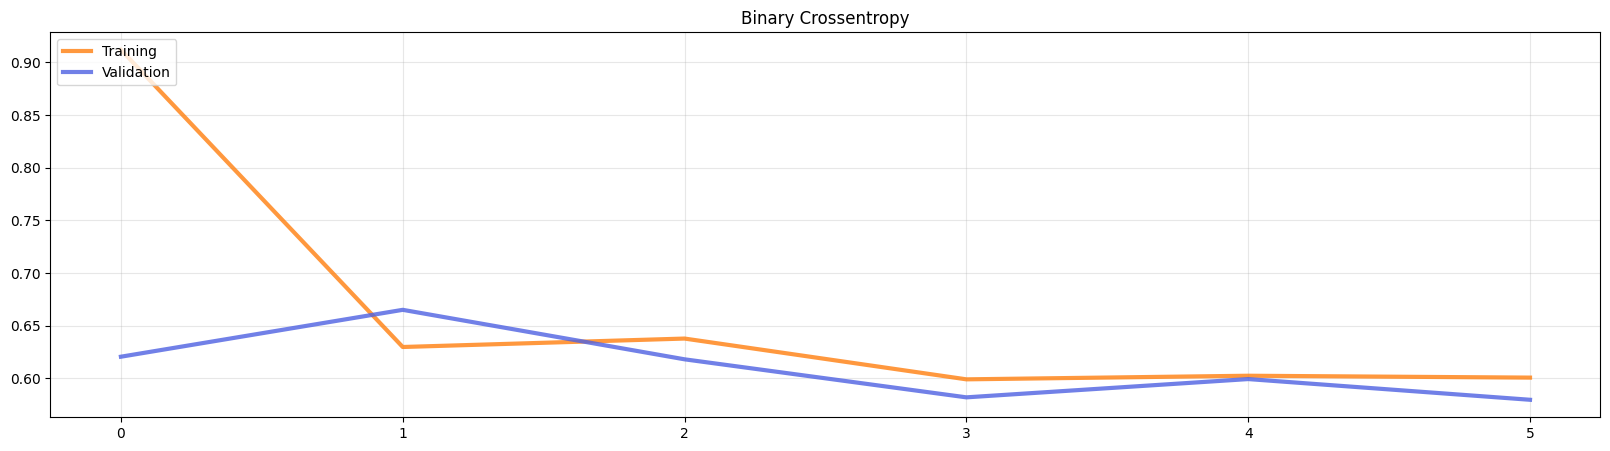

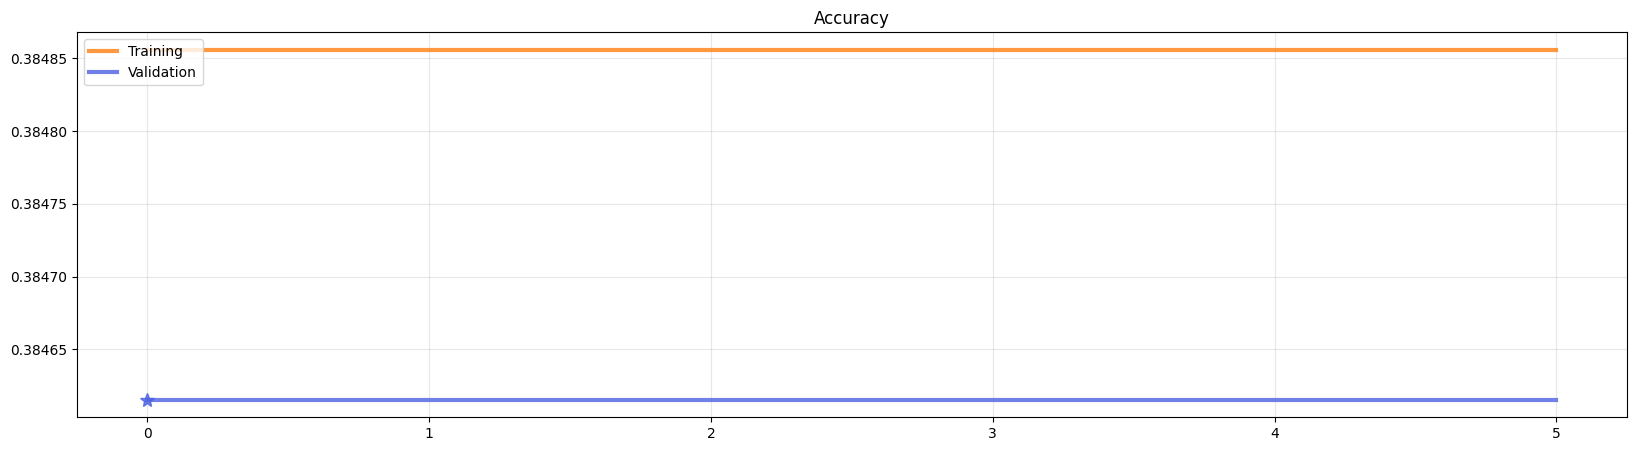

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()